In [1]:
from collections import defaultdict
import copy
import matplotlib.pyplot as plt
from circuit.parser import get_circuit_duration
from plot.plot import plot_duration_fidelity, plot_top_ratio, find_error_path
import random
import numpy as np

from circuit import gen_random_circuits, label_ground_truth_fidelity
from upstream import RandomwalkModel
from downstream import FidelityModel
from simulator import NoiseSimulator
from utils.backend import devide_chip, gen_grid_topology, get_grid_neighbor_info, Backend, topology_to_coupling_map
from utils.backend import default_basis_single_gates, default_basis_two_gates
import pickle


In [2]:
with open(f"quct_model.pkl","rb")as f:
    downstream_model = pickle.load(f)
upstream_model = downstream_model.upstream_model

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
split = [321,331,11,26,177,243,53,267,302,79,222,292,227,199,326,290,206,253,348,263,191,201,224,6,15,276,16,49,116,327,100,216,247,150,347,10,122,29,345,161,273,264,13,145,195,160,180,217,27,118,133,335,86,61,30,85,172,281,229,260,300,92,357,285,288,223,67,238,101,125,277,42,132,1,34,337,176,93,342,162,341,246,325,57,220,266,164,270,244,190,332,169,87,60,19,189,136,232,252,110,55,289,50,157,205,233,259,159,278,68,352,240,283,306,225,74,126,349,46,179,84,184,317,315,88,38,148,97,77,261,128,20,47,156,171,167,124,90,251,51,104,194,311,89,24,303,353,138,214,14,257,186,330,115,175,202,56,230,72,187,310,192,4,320,81,91,258,5,297,203,239,40,151,158,344,343,96,44,241,237,308,105,336,242,294,129,279,108,178,204,328,119,271,304,23,112,312,146,318,282,70,153,313,293,322,69,346,274,12,102,215,193,207,340,120,183,198,185,52,143,323,109,8,37,319,211,152,71,168,117,22,339,269,309,236,94,18,213,235,181,48,262,173,208,314,234,219,249,32,299,33,121,256,200,174,135,45,76,3,228,268,355,188,66,59,7,0,250,83,134,356,291,41,170,123,197,338,103,154,111,95,221,196,28,182,286,295,350,301,25,254,255,2,209,218,142,265,329,36,107,106,272,245,139,358,58,113,351,137,316,149,99,296,39,127,35,155,73,80,163,147,141,114,284,31,275,62,324,75,165,131,333,212,334,305,166,43,63,354,21,226,248,17,298,64,9,231,307,144,280,359,210,130,78,54,287,65,82,140,98]


In [4]:
from scipy import io as sio
all_results_load = sio.loadmat("1800.mat")
last = sio.loadmat("300_last.mat")

In [5]:
with open('test_dataset.pkl','rb') as f:
    dataset_300 = pickle.load(f)
    print(len(dataset_300))
    for i, cir in enumerate(dataset_300):
        assert 'devide_qubits' not in cir or cir['devide_qubits'] is None


360


In [6]:
single_average_error_rb = {0: 0.9994094148043156, # rb
 1: 0.9993508083886652,
 2: 0.9993513578387458,
 3: 0.9996978330672296,
 4: 0.9997258463524775,
 5: 0.9993898065578337,
 6: 0.9998335484697743,
 7: 0.9997460044815009,
 8: 0.9997219426985601,
 9: 0.9992924485427597,
 10: 0.9994018918682177,
 11: 0.9998410411794697,
 12: 0.9994231683912435,
 13: 0.9995938422219371,
 14: 0.9947661045069707,
 15: 0.9997576786354693,
 16: 0.9998387638441334,
 17: 0.9996691783504945}
couple_average_error_rb = {(5,11): 0.993651602350742, # rb
 (11,17): 0.9943374306798481,
 (4,5): 0.9810612795342519,
 (10,11): 0.9915544427978213,
 (16,17): 0.9908639448675425,
 (4,10): 0.9914941121128581,
 (10,16): 0.9868303060599511,
 (3,4): 0.9899226069903224,
 (9,10): 0.9945250360193374,
 (15,16): 0.9933864398113101,
 (3,9): 0.991508018299962,
 (9,15): 0.993773364368622,
 (2,3): 0.9802169505904027,
 (8,9): 0.9912794178832776,
 (14,15): 0.9867247971867894,
 (2,8): 0.9765590682588615,
 (8,14): 0.9863913339619792,
 (1,2): 0.9713229087974011,
 (7,8): 0.9908463216114999,
 (13,14): 0.9564265490465305,
 (1,7): 0.9856880460026779,
 (7,13): 0.9935440562158602,
 (0,1): 0.9833453296232256,
 (6,7): 0.9939901490743566,
 (12,13): 0.9821366244436676,
 (0,6): 0.9861987068804432,
 (6,12): 0.9863008252688662}
single_average_error_xeb = {0: 0.9994, #xeb
 1: 0.99956,
 2: 0.99918,
 3: 0.99976,
 4: 0.9994,
 5: 0.99962,
 6: 0.99989,
 7: 0.99973,
 8: 0.99961,
 9: 0.99941,
 10: 0.99975,
 11: 0.99939,
 12: 0.99873,
 13: 0.9996,
 14: 0.99946,
 15: 0.99976,
 16: 0.99977,
 17: 0.99975}
couple_average_error_xeb = {(5, 11): 0.98602, # xeb
 (11, 17): 0.99561,
 (4, 5): 0.99482,
 (10, 11): 0.99529,
 (16, 17): 0.996,
 (4, 10): 0.9908,
 (10, 16): 0.99501,
 (3, 4): 0.99738,
 (9, 10): 0.99373,
 (15, 16): 0.9934499999999999,
 (3, 9): 0.99659,
 (9, 15): 0.99357,
 (2, 3): 0.99353,
 (8, 9): 0.98778,
 (14, 15): 0.9956,
 (2, 8): 0.98862,
 (8, 14): 0.99711,
 (1, 2): 0.99445,
 (7, 8): 0.97725,
 (13, 14): 0.99527,
 (1, 7): 0.99098,
 (7, 13): 0.99424,
 (0, 1): 0.99394,
 (6, 7): 0.99452,
 (12, 13): 0.99141,
 (0, 6): 0.99474,
 (6, 12): 0.99312}
from upstream.randomwalk_model import extract_device
def get_rb_fidelity(circuit_info):
    fidelity = 1
    for gate in circuit_info['gates']:
        device = extract_device(gate)
        if isinstance(device,tuple):
            if 'map' in circuit_info:
                device = (circuit_info['map'][device[0]],circuit_info['map'][device[1]])
            fidelity = fidelity * couple_average_error_rb[device]
        else:
            if 'map' in circuit_info:
                device = circuit_info['map'][device]
            fidelity = fidelity * single_average_error_rb[device]
    return fidelity #* np.product((measure0_fidelity + measure1_fidelity) / 2)
from upstream.randomwalk_model import extract_device
def get_xeb_fidelity(circuit_info):
    fidelity = 1
    for gate in circuit_info['gates']:
        device = extract_device(gate)
        if isinstance(device,tuple):
            if 'map' in circuit_info:
                device = (circuit_info['map'][device[0]],circuit_info['map'][device[1]])
            fidelity = fidelity * couple_average_error_xeb[device]
        else:
            if 'map' in circuit_info:
                device = circuit_info['map'][device]
            fidelity = fidelity * single_average_error_xeb[device]
    return fidelity #* np.product((measure0_fidelity + measure1_fidelity) / 2)

In [7]:
predicts,xebs,rbs = [],[],[]
for i, cir in enumerate(dataset_300):
    new_cir = upstream_model.vectorize(cir)
    predict = downstream_model.predict_fidelity(new_cir)
    predicts.append(predict)
    xebs.append(get_xeb_fidelity(new_cir))
    rbs.append(get_rb_fidelity(new_cir))

In [8]:
reals = []
for day in range(1,5):
    cnt = 0
    real = []
    for idx, cir in enumerate(dataset_300):
        state_count = dict([(s, cnt) for s, cnt in zip(
                            np.squeeze(all_results_load[f'circuit No.{day}.{idx} state_index']), 
                            np.squeeze(all_results_load[f'circuit No.{day}.{idx} measure_counts']))])
        cir['state_count'] = state_count
        if 0 not in state_count:
            cnt += 1
            continue
        real.append(state_count[0] / 1000)
    reals.append(real)
    print(cnt)

real = []
for idx, cir in enumerate(dataset_300):
    state_count = dict([(s, cnt) for s, cnt in zip(
                        np.squeeze(last[f'circuit No.{4}.{idx} state_index']), 
                        np.squeeze(last[f'circuit No.{4}.{idx} measure_counts']))])
    cir['state_count'] = state_count
    if 0 not in state_count:
        cnt += 1
        continue
    real.append(state_count[0] / 1000)
reals.append(real)        

0
0
0
0


In [9]:
with open('quest_predict.pkl','rb')as f:
    quest = pickle.load(f)

In [11]:
import  matplotlib.pyplot as plt
deltas_rb = []
deltas_xeb = []
deltas_quct = []
deltas_quest = []

predicts = np.array(predicts)[split[-120:]]
xebs = np.array(xebs)[split[-120:]]
rbs = np.array(rbs)[split[-120:]]
quest = np.array(quest)[split[-120:]]

for real in reals:
    real= np.array(real)[split[-120:]]

    deltas_quct.append(np.abs(real - predicts).mean())
    deltas_rb.append(np.abs(rbs - real).mean())
    deltas_xeb.append(np.abs(xebs - real).mean())
    deltas_quest.append(np.abs(quest - real).mean())

In [12]:
error_params = downstream_model.error_params
dataset_300 = np.array(dataset_300)
reals= np.array(reals)
fine1 = []
for day in range(5):
    for cir, label in zip(dataset_300, reals[day]):
        cir['ground_truth_fidelity'] = label
    downstream_model.finetune(dataset_300[split[:120]], error_params)
    predicts = []
    for cir in dataset_300[split[-120:]]:
        new_cir = upstream_model.vectorize(cir)
        predicts.append(downstream_model.predict_fidelity(new_cir))
    fine1.append( np.abs(np.array(predicts) - np.array(reals[day][split[-120:]])).mean() )

n_instruction2circuit_infos =  {50: 13, 70: 10, 100: 13, 90: 16, 40: 12, 80: 13, 110: 14, 60: 9}


epoch: 0, 	 epoch loss = 93.95149230957031, 	 test loss = 12.457667350769043
epoch: 1, 	 epoch loss = 91.66570281982422, 	 test loss = 12.157905578613281
epoch: 2, 	 epoch loss = 89.50695037841797, 	 test loss = 11.87140941619873
epoch: 3, 	 epoch loss = 87.41867065429688, 	 test loss = 11.60881519317627
epoch: 4, 	 epoch loss = 85.51119995117188, 	 test loss = 11.350845336914062
epoch: 5, 	 epoch loss = 83.70381164550781, 	 test loss = 11.104084968566895
epoch: 6, 	 epoch loss = 81.93002319335938, 	 test loss = 10.879237174987793
epoch: 7, 	 epoch loss = 80.33631134033203, 	 test loss = 10.664960861206055
epoch: 8, 	 epoch loss = 78.79969787597656, 	 test loss = 10.460021018981934
epoch: 9, 	 epoch loss = 77.37461853027344, 	 test loss = 10.258262634277344
epoch: 10, 	 epoch loss = 75.97897338867188, 	 test loss = 10.070414543151855
epoch: 11, 	 epoch loss = 74.6758804321289, 	 test loss = 9.890460014343262
epoch: 12, 	 epoch loss = 73.43748474121094, 	 test loss = 9.723922729492188
e

In [13]:
error_params = downstream_model.error_params
dataset_300 = np.array(dataset_300)
reals= np.array(reals)
fine2 = []
for day in range(5):
    for cir, label in zip(dataset_300, reals[day]):
        cir['ground_truth_fidelity'] = label
    downstream_model.finetune(dataset_300[split[:240]], error_params)
    predicts = []
    for cir in dataset_300[split[-120:]]:
        new_cir = upstream_model.vectorize(cir)
        predicts.append(downstream_model.predict_fidelity(new_cir))
    fine2.append( np.abs(np.array(predicts) - np.array(reals[day][split[-120:]])).mean() )

n_instruction2circuit_infos =  {70: 23, 40: 28, 100: 26, 80: 33, 50: 28, 110: 27, 60: 28, 90: 27}
epoch: 0, 	 epoch loss = 175.12091064453125, 	 test loss = 2.869445562362671
epoch: 1, 	 epoch loss = 173.19866943359375, 	 test loss = 2.8774378299713135
epoch: 2, 	 epoch loss = 171.44371032714844, 	 test loss = 2.888667583465576
epoch: 3, 	 epoch loss = 169.766357421875, 	 test loss = 2.9005818367004395
epoch: 4, 	 epoch loss = 168.03713989257812, 	 test loss = 2.9114840030670166
epoch: 5, 	 epoch loss = 166.62899780273438, 	 test loss = 2.9269206523895264
epoch: 6, 	 epoch loss = 165.04678344726562, 	 test loss = 2.939587116241455
epoch: 7, 	 epoch loss = 163.7076873779297, 	 test loss = 2.956149101257324
epoch: 8, 	 epoch loss = 162.26844787597656, 	 test loss = 2.972489595413208
epoch: 9, 	 epoch loss = 160.9131317138672, 	 test loss = 2.986872434616089
epoch: 10, 	 epoch loss = 159.7037353515625, 	 test loss = 3.0032379627227783
taining error params finishs
n_instruction2circuit_inf

[0.3409772355234587, 0.349335568856792, 0.3766105688567921, 0.34403556885679204, 0.3495105688567921] [0.4081048663777112, 0.41646319971104456, 0.44373819971104456, 0.41116319971104454, 0.41663819971104454] [0.08849956518411635, 0.09091407967408499, 0.11247380585273108, 0.08862263633012771, 0.09137093613147736] [0.16178986370687679, 0.1694982167574266, 0.19692378002280986, 0.16442566893423594, 0.1696732167574266]


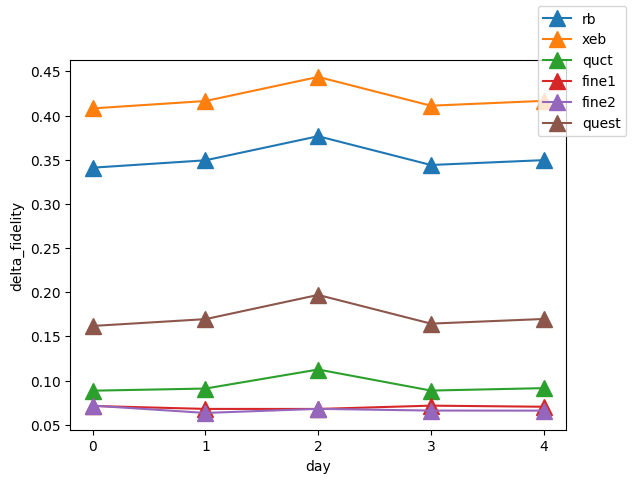

In [14]:
fig, axes = plt.subplots()
x = np.arange(len(deltas_rb))
axes.plot(x, deltas_rb , marker = '^',markersize= 12,label = 'rb')
axes.plot(x, deltas_xeb, marker = '^',markersize= 12, label = 'xeb')
axes.plot(x, deltas_quct, marker = '^',markersize= 12, label = 'quct')
axes.plot(x, fine1, marker = '^',markersize= 12, label = 'fine1')
axes.plot(x, fine2, marker = '^',markersize= 12, label = 'fine2')
axes.plot(x, deltas_quest, marker = '^',markersize= 12, label = 'quest')
axes.set_xlabel('day')
axes.set_ylabel('delta_fidelity')
axes.set_xticks(x)
print(deltas_rb,deltas_xeb,deltas_quct,deltas_quest)
fig.legend()
fig.savefig('time_drift_with_finetune.svg')
# [0.3409772355234587, 0.349335568856792, 0.3766105688567921, 0.34403556885679204, 0.3495105688567921] [0.4081048663777112, 0.41646319971104456, 0.44373819971104456, 0.41116319971104454, 0.41663819971104454] [0.08849956518411635, 0.09091407967408499, 0.11247380585273108, 0.08862263633012771, 0.09137093613147736] [0.16178986370687679, 0.1694982167574266, 0.19692378002280986, 0.16442566893423594, 0.1696732167574266]